In [35]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [36]:
# 1. Load the aijobs.net dataset
print("Loading AI/ML Salary Dataset from aijobs.net...")
df = pd.read_csv('salaries.csv')  # Download from https://aijobs.net/salaries/download/

print("Dataset shape:", df.shape)
print("\nDataset columns:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Loading AI/ML Salary Dataset from aijobs.net...
Dataset shape: (148521, 11)

Dataset columns:
['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

First 5 rows:
   work_year experience_level employment_type          job_title  salary  \
0       2025               SE              FT  Software Engineer  218900   
1       2025               SE              FT  Software Engineer  186065   
2       2025               SE              FT    System Engineer  158000   
3       2025               SE              FT    System Engineer  140000   
4       2025               SE              FT      Data Engineer  164600   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD         218900                 US           100   
1             USD         186065                 US           100   
2             USD         158000         

In [37]:
# 2. Data exploration and preprocessing
print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nSalary statistics:")
print(df['salary_in_usd'].describe())

# Handle missing values
df = df.dropna()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148521 entries, 0 to 148520
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           148521 non-null  int64 
 1   experience_level    148521 non-null  object
 2   employment_type     148521 non-null  object
 3   job_title           148521 non-null  object
 4   salary              148521 non-null  int64 
 5   salary_currency     148521 non-null  object
 6   salary_in_usd       148521 non-null  int64 
 7   employee_residence  148521 non-null  object
 8   remote_ratio        148521 non-null  int64 
 9   company_location    148521 non-null  object
 10  company_size        148521 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.5+ MB
None

Missing values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd       

In [38]:
# 3. Feature engineering
# Create experience level mapping
experience_mapping = {
    'EN': 1,  # Entry-level
    'MI': 2,  # Mid-level
    'SE': 3,  # Senior-level
    'EX': 4   # Executive-level
}
df['experience_numeric'] = df['experience_level'].map(experience_mapping)

# Create employment type mapping
employment_mapping = {
    'PT': 1,  # Part-time
    'FT': 4,  # Full-time (higher weight)
    'CT': 2,  # Contract
    'FL': 1   # Freelance
}
df['employment_numeric'] = df['employment_type'].map(employment_mapping)

In [39]:
# Create company size mapping
company_size_mapping = {
    'S': 1,  # Small (< 50 employees)
    'M': 2,  # Medium (50-250 employees)
    'L': 3   # Large (> 250 employees)
}
df['company_size_numeric'] = df['company_size'].map(company_size_mapping)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['job_title', 'employee_residence', 'company_location']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [40]:
# 4. Feature selection for modeling
feature_columns = [
    'work_year',
    'experience_numeric',
    'employment_numeric', 
    'remote_ratio',
    'company_size_numeric',
    'job_title_encoded',
    'employee_residence_encoded',
    'company_location_encoded'
]

X = df[feature_columns]
y = df['salary_in_usd']

print(f"\nFeatures used: {feature_columns}")
print(f"Target variable: salary_in_usd")
print(f"Feature matrix shape: {X.shape}")


Features used: ['work_year', 'experience_numeric', 'employment_numeric', 'remote_ratio', 'company_size_numeric', 'job_title_encoded', 'employee_residence_encoded', 'company_location_encoded']
Target variable: salary_in_usd
Feature matrix shape: (148521, 8)


In [41]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['experience_level']
)

In [42]:
# 6. Feature scaling for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# 7. Model training and comparison
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    )
}

results = {}
predictions = {}

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    predictions[name] = y_pred
    
    print(f"{name} Results:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")


MODEL TRAINING AND EVALUATION

Training Linear Regression...
Linear Regression Results:
  R² Score: 0.1943
  MAE: $49,395.06
  RMSE: $66,316.25

Training Random Forest...
Random Forest Results:
  R² Score: 0.3068
  MAE: $45,125.78
  RMSE: $61,512.12

Training Gradient Boosting...
Gradient Boosting Results:
  R² Score: 0.3085
  MAE: $45,016.04
  RMSE: $61,436.40


In [44]:
# 8. Select and save best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best R² Score: {results[best_model_name]['R2']:.4f}")

# Save model components
joblib.dump(best_model, 'ai_salary_model.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(f"\nModel saved as: ai_salary_model.pkl")


🏆 Best Model: Gradient Boosting
Best R² Score: 0.3085

Model saved as: ai_salary_model.pkl


In [45]:
# 9. Comprehensive visualizations
plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

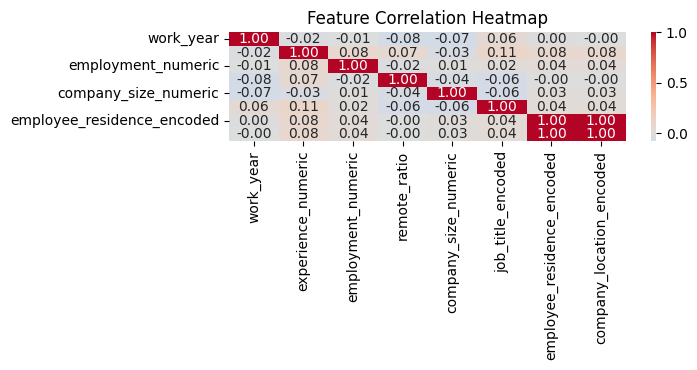

In [81]:
# 1. Correlation heatmap
plt.subplot(3, 1, 1)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout() 

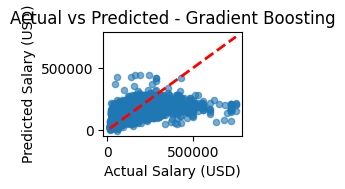

In [82]:
# 2. Actual vs Predicted (Best Model)
plt.subplot(3, 3, 2)
y_pred_best = predictions[best_model_name]
plt.scatter(y_test, y_pred_best, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.tight_layout() 

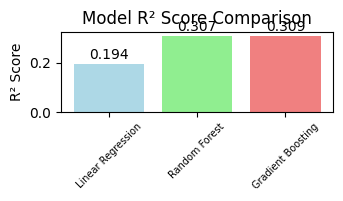

In [84]:
# 3. Model comparison
plt.subplot(3, 2, 1)
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
bars = plt.bar(model_names, r2_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Model R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45, fontsize=7)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()     

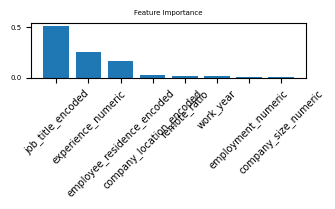

In [77]:
# 4. Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    plt.subplot(3, 2, 2)
    feature_importance = best_model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    plt.bar(range(len(feature_importance)), feature_importance[indices])
    plt.title('Feature Importance', fontsize=5)
    plt.xticks(range(len(feature_importance)), 
               [feature_columns[i] for i in indices], rotation=45, fontsize=7)
    plt.yticks(fontsize=5)
    plt.tight_layout()  

Text(0.5, 1.0, 'Residual Plot')

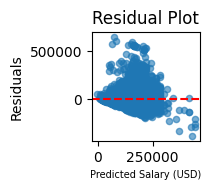

In [88]:
# 5. Residual plot
plt.subplot(3, 4, 3)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Salary (USD)', fontsize=7)
plt.ylabel('Residuals')
plt.title('Residual Plot')

Text(0, 0.5, 'Salary (USD)')

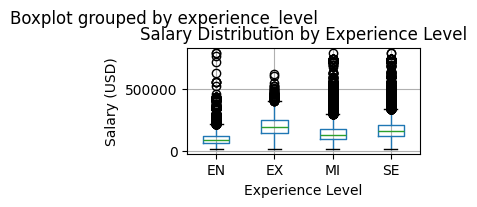

In [96]:
# 6. Salary distribution by experience level
plt.subplot(3, 2, 2)
df.boxplot(column='salary_in_usd', by='experience_level', ax=plt.gca())
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')

Text(0.5, 0, 'Average Salary (USD)')

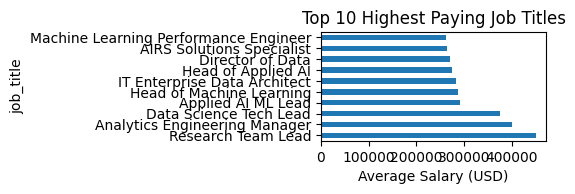

In [99]:
# 7. Salary by job title (top 10)
plt.subplot(3, 2, 4)
top_jobs = df.groupby('job_title')['salary_in_usd'].mean().nlargest(10)
top_jobs.plot(kind='barh')
plt.title('Top 10 Highest Paying Job Titles')
plt.xlabel('Average Salary (USD)')

Text(0, 0.5, 'Average Salary (USD)')

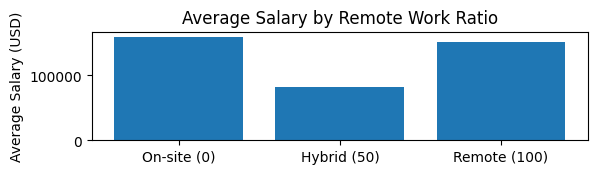

In [108]:
# 8. Remote work vs Salary
plt.subplot(3, 1, 2)
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].mean()
plt.bar(['On-site (0)', 'Hybrid (50)', 'Remote (100)'], remote_salary.values)
plt.title('Average Salary by Remote Work Ratio')
plt.ylabel('Average Salary (USD)')

Text(0, 0.5, 'Average Salary (USD)')

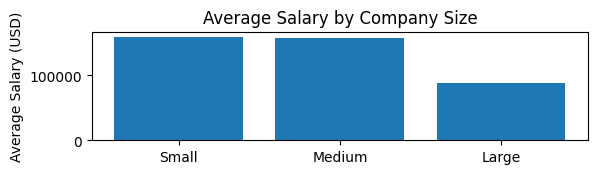

In [109]:
# 9. Company size vs Salary
plt.subplot(3, 1, 2)
size_salary = df.groupby('company_size')['salary_in_usd'].mean()
plt.bar(['Small', 'Medium', 'Large'], size_salary.values)
plt.title('Average Salary by Company Size')
plt.ylabel('Average Salary (USD)')

Text(0, 0.5, 'Average Salary (USD)')

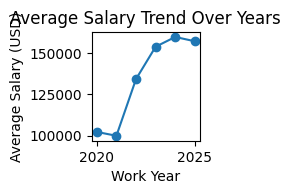

In [55]:
plt.subplot(3, 4, 10)
yearly_salary = df.groupby('work_year')['salary_in_usd'].mean()
plt.plot(yearly_salary.index, yearly_salary.values, marker='o')
plt.title('Average Salary Trend Over Years')
plt.xlabel('Work Year')
plt.ylabel('Average Salary (USD)')

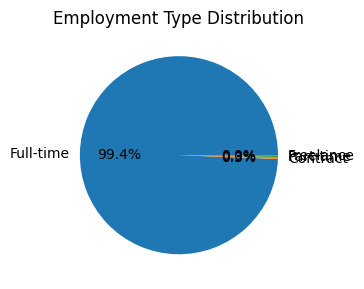

In [127]:
# 11. Employment type distribution
plt.subplot(1, 2, 2)
employment_counts = df['employment_type'].value_counts()
plt.pie(employment_counts.values, labels=['Full-time', 'Contract', 'Part-time', 'Freelance'], 
        autopct='%1.1f%%')
plt.title('Employment Type Distribution')
plt.tight_layout() 


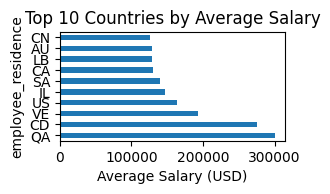

In [133]:
# 12. Geographic salary distribution (top countries)
plt.subplot(3, 2, 1)
country_salary = df.groupby('employee_residence')['salary_in_usd'].mean().nlargest(10)
country_salary.plot(kind='barh')
plt.title('Top 10 Countries by Average Salary')
plt.xlabel('Average Salary (USD)')


plt.savefig('ai_ml_salary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# 10. Generate insights
print("\n" + "="*50)
print("KEY INSIGHTS FROM THE ANALYSIS")
print("="*50)

print(f" Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Years covered: {df['work_year'].min()} - {df['work_year'].max()}")
print(f"   • Unique job titles: {df['job_title'].nunique()}")
print(f"   • Countries represented: {df['employee_residence'].nunique()}")

print(f"\n Salary Insights:")
print(f"   • Average salary: ${df['salary_in_usd'].mean():,.2f}")
print(f"   • Median salary: ${df['salary_in_usd'].median():,.2f}")
print(f"   • Salary range: ${df['salary_in_usd'].min():,.2f} - ${df['salary_in_usd'].max():,.2f}")
print(f"\n Experience Level Impact:")
for level in ['EN', 'MI', 'SE', 'EX']:
    avg_salary = df[df['experience_level'] == level]['salary_in_usd'].mean()
    print(f"   • {level}: ${avg_salary:,.2f}")

print(f"\n Remote Work Impact:")
for ratio in [0, 50, 100]:
    avg_salary = df[df['remote_ratio'] == ratio]['salary_in_usd'].mean()
    work_type = ['On-site', 'Hybrid', 'Fully Remote'][ratio//50]
    print(f"   • {work_type}: ${avg_salary:,.2f}")

print(f"\n Top 5 Highest Paying Jobs:")
top_jobs = df.groupby('job_title')['salary_in_usd'].mean().nlargest(5)
for i, (job, salary) in enumerate(top_jobs.items(), 1):
    print(f"   {i}. {job}: ${salary:,.2f}")
print("\n Model files saved successfully!")
print("Files created:")
print("• ai_salary_model.pkl - Trained model")
print("• feature_columns.pkl - Feature names")
print("• label_encoders.pkl - Categorical encoders")
print("• scaler.pkl - Feature scaler")
print("• ai_ml_salary_analysis.png - Analysis visualizations")    


KEY INSIGHTS FROM THE ANALYSIS
 Dataset Overview:
   • Total records: 148,521
   • Years covered: 2020 - 2025
   • Unique job titles: 419
   • Countries represented: 104

 Salary Insights:
   • Average salary: $157,518.52
   • Median salary: $146,100.00
   • Salary range: $15,000.00 - $800,000.00

 Experience Level Impact:
   • EN: $98,902.75
   • MI: $142,443.91
   • SE: $172,667.35
   • EX: $202,364.66

 Remote Work Impact:
   • On-site: $159,331.62
   • Hybrid: $81,556.39
   • Fully Remote: $151,429.74

 Top 5 Highest Paying Jobs:
   1. Research Team Lead: $450,000.00
   2. Analytics Engineering Manager: $399,880.00
   3. Data Science Tech Lead: $375,000.00
   4. Applied AI ML Lead: $292,500.00
   5. Head of Machine Learning: $286,805.74

 Model files saved successfully!
Files created:
• ai_salary_model.pkl - Trained model
• feature_columns.pkl - Feature names
• label_encoders.pkl - Categorical encoders
• scaler.pkl - Feature scaler
• ai_ml_salary_analysis.png - Analysis visualizat